In [1]:
import os
import cv2
import random
import datetime
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import defaultdict

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim import Adam

from src.utils.utils_generate_samples import generate_shape_image
from src.models.CoAttentionModel import CoAttentionModel

### Dataset

In [2]:
class PairDataset:
    def __init__(self, df, size):
        self.df = df
        self.size = size

    def __len__(self):
        return self.size

    def get_item(self, index):
        
        shape = self.df.at[index, 'shape']
        size = self.df.at[index, 'size']
        x = self.df.at[index, 'x']
        y = self.df.at[index, 'y']
        angle = self.df.at[index, 'angle']
        
        return generate_shape_image(shape=shape, s=size, position=(x, y), angle=angle)
    
    def __getitem__(self, index):

        random_pair = self.df.sample(n=2).index.tolist()

        img1, shape1 = self.get_item(random_pair[0])
        img2, shape2 = self.get_item(random_pair[1])

        # img1, shape1 = generate_shape_image(image_size=(32, 32), min_size=5, )
        # img2, shape2 = generate_shape_image(image_size=(32, 32), min_size=5,)
        
        ### Target
        target = 0
        if shape1 == shape2:
            target = 1
            
        ### Preprocess
        tensor1 = torch.from_numpy(np.array(img1, dtype=np.float32)).unsqueeze(0) / 255.
        tensor2 = torch.from_numpy(np.array(img2, dtype=np.float32)).unsqueeze(0) / 255.

        return tensor1, tensor2, target

In [3]:
phase_range = ['train', 'val']
df = pd.read_csv('data/train_val_test_split.csv')

phase_to_size = {
    'train': 20_000,
    'val': 4_000
}

datasets = {
    phase: PairDataset(df=df[df.split == phase], size=phase_to_size[phase])
        for phase in phase_range
}

BATCH_SIZE = 128
dataloaders = {
    phase: DataLoader(datasets[phase], batch_size=BATCH_SIZE, 
                      shuffle=True if phase == 'train' else False)
        for phase in phase_range
}

In [4]:
datasets['train'].df['shape'].value_counts()

circle    5000
square    5000
Name: shape, dtype: int64

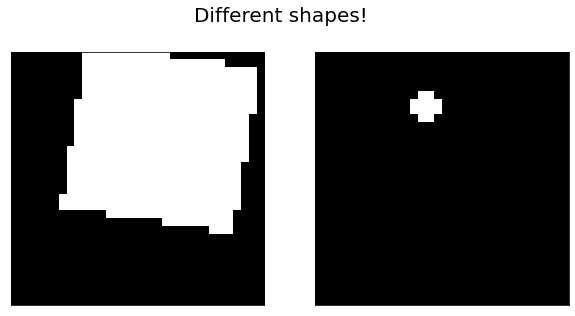

In [5]:
img1, img2, target = next(iter(dataloaders['train']))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img1.numpy()[0][0], cmap='Greys')
axs[1].imshow(img2.numpy()[0][0], cmap='Greys')

if target[0] == 1:
    plt.suptitle('Same shapes!', fontsize=20)
else:
    plt.suptitle('Different shapes!', fontsize=20)

for i in range(2):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

# Model

In [ ]:
model = CoAttentionModel()
# model = model.to(device)

# summary(model, input_size=(1, 32, 32))
x = torch.randn((2, 1, 32, 32))#.to(device)
model(x, x)

In [11]:
count = 0
for p in model.parameters():
    count += p.numel()
print('Number of params:', count)

Number of params: 1507105


### Train

In [12]:
class BCELossCustom(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()

        self.metrics = defaultdict(float)
        self.df = pd.DataFrame(columns=['epoch', 'phase', 'lr', 'itr', 'loss', 'accuracy', 'precision', 'recall'])
        self.loss_fn = nn.BCEWithLogitsLoss()
        
    def init_metrics(self):
        self.metrics = defaultdict(float)

    def update_dataframe(self, epoch, phase, itr, epoch_samples):
        self.calc_aggr_metrics()
        self.df.loc[df.shape[0]] = [
            epoch, phase, get_lr(optimizer), itr, 
            self.metrics['loss'] / epoch_samples, 
            self.metrics['accuracy'],
            self.metrics['precision'],
            self.metrics['recall']
        ]

    def print_metrics(self, epoch, epoch_samples, phase, ):  
        self.calc_aggr_metrics()
        
        outputs = []
        for k in self.metrics.keys():
            if k == 'loss':
                outputs.append("{}: {:4f}".format(k, self.metrics[k] / epoch_samples))
            else:
                outputs.append("{}: {:4f}".format(k, self.metrics[k] ))

        print("{} {}: {}".format(epoch, phase, ", ".join(outputs)))  
        
    def calc_metrics(self, preds, targets, threshold=0.5):
        probs = torch.sigmoid(preds)
        predictions = (probs > threshold).int()
        
        self.metrics['TP'] += ((predictions == 1) & (targets == 1)).sum().item()
        self.metrics['FP'] += ((predictions == 1) & (targets == 0)).sum().item()
        self.metrics['TN'] += ((predictions == 0) & (targets == 0)).sum().item()
        self.metrics['FN'] += ((predictions == 0) & (targets == 1)).sum().item()
        
    def calc_aggr_metrics(self):
        
        correct = (self.metrics['TP'] + self.metrics['TN'])
        count = (self.metrics['TP'] + self.metrics['FP'] + self.metrics['TN'] + self.metrics['FN'])
        
        self.metrics['accuracy'] = correct / count
        self.metrics['precision'] = self.metrics['TP'] / (self.metrics['TP'] + self.metrics['FP']) \
                    if (self.metrics['TP'] + self.metrics['FP']) > 0 else 0
        self.metrics['recall'] = self.metrics['TP'] / (self.metrics['TP'] + self.metrics['FN']) \
                    if (self.metrics['TP'] + self.metrics['FN']) > 0 else 0

    def forward(self, preds, targets):
        preds = preds.squeeze(dim=1)

        loss = self.loss_fn(preds, targets.float())
        self.metrics['loss'] += loss.cpu().item()
        
        self.calc_metrics(preds, targets)
        return loss

def init_dir(path):
    ts = str(datetime.datetime.now().replace(microsecond=0))
    ts = ts.replace('-', '_')
    ts = ts.replace(':', '_')
    ts = ts.replace(' ', 'T')

    folder_path = os.path.join(path, ts)
    os.makedirs(folder_path)
    return folder_path

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


In [13]:
if torch.cuda.is_available():
    device=torch.device("cuda")
    print('cuda is available!!!!')
elif not torch.cuda.is_available():
    print('cuda not available! Training initialized on cpu ...')
    device=torch.device("cpu")


cuda is available!!!!


In [28]:
### Model
model = CoAttentionModel()
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [29]:
### Learning parameters

TRAINING_EPOCH = 30

optimizer = Adam(params=model.parameters(),  lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

criterion = BCELossCustom()

In [30]:
# scheduler.get_lr()

In [31]:
model_dir = init_dir('data/')
folder = model_dir.split('/')[-1]
df_path = model_dir + f"/df_logs_{folder}.csv"

print_per_iter = 1000 ### don't want to see intermidiate results
for epoch in range(TRAINING_EPOCH):
    for p, phase in enumerate(phase_range):
        criterion.init_metrics()

        ## Model state
        if phase == 'train':
            model.train()
            scheduler.step()
        else:
            model.eval()

        ### Iterate
        epoch_samples = 0
        for itr, (img1, img2, targets) in tqdm(enumerate(dataloaders[phase])): 
            if phase == 'train':
                optimizer.zero_grad() 
            
            with torch.set_grad_enabled(phase == 'train'):
                out = model(img1.to(device), img2.to(device))
                
            epoch_samples += img1.shape[0]
            
            loss = criterion(out, targets.to(device))
            ### Backward
            if phase == 'train':
                loss.backward()
                optimizer.step()
                

            if itr % print_per_iter == (print_per_iter - 1):
                criterion.print_metrics(epoch+1, itr + 1, phase, )
                criterion.update_dataframe(epoch, phase, itr, epoch_samples)
                criterion.df.to_csv(df_path, index=False)

        criterion.print_metrics(epoch+1, itr + 1, phase, )
        criterion.update_dataframe(epoch, phase, itr, epoch_samples)
        criterion.df.to_csv(df_path, index=False)
        
        if phase == 'val':
            epoch_loss = criterion.metrics['loss'] / itr
            model_suffix = "weight.epoch_{}_loss_{}_{}.pth".format(epoch+1, phase, epoch_loss)
            model_path = os.path.join(model_dir, model_suffix)
            torch.save(model.state_dict(), model_path) 

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
157it [00:16,  9.43it/s]


1 train: loss: 0.678995, TP: 5564.000000, FP: 4601.000000, TN: 5443.000000, FN: 4392.000000, accuracy: 0.550350, precision: 0.547368, recall: 0.558859


32it [00:02, 12.84it/s]


1 val: loss: 0.784285, TP: 981.000000, FP: 850.000000, TN: 1154.000000, FN: 1015.000000, accuracy: 0.533750, precision: 0.535773, recall: 0.491483


157it [00:16,  9.49it/s]


2 train: loss: 0.195396, TP: 9246.000000, FP: 810.000000, TN: 9318.000000, FN: 626.000000, accuracy: 0.928200, precision: 0.919451, recall: 0.936588


32it [00:02, 12.89it/s]


2 val: loss: 0.485089, TP: 1831.000000, FP: 523.000000, TN: 1426.000000, FN: 220.000000, accuracy: 0.814250, precision: 0.777825, recall: 0.892735


157it [00:16,  9.44it/s]


3 train: loss: 0.048690, TP: 9764.000000, FP: 155.000000, TN: 9950.000000, FN: 131.000000, accuracy: 0.985700, precision: 0.984373, recall: 0.986761


32it [00:02, 12.70it/s]


3 val: loss: 0.056185, TP: 1933.000000, FP: 32.000000, TN: 1997.000000, FN: 38.000000, accuracy: 0.982500, precision: 0.983715, recall: 0.980720


157it [00:16,  9.40it/s]


4 train: loss: 0.023698, TP: 10110.000000, FP: 76.000000, TN: 9747.000000, FN: 67.000000, accuracy: 0.992850, precision: 0.992539, recall: 0.993417


32it [00:02, 12.89it/s]


4 val: loss: 0.058089, TP: 2022.000000, FP: 31.000000, TN: 1922.000000, FN: 25.000000, accuracy: 0.986000, precision: 0.984900, recall: 0.987787


157it [00:16,  9.30it/s]


5 train: loss: 0.037028, TP: 9869.000000, FP: 116.000000, TN: 9900.000000, FN: 115.000000, accuracy: 0.988450, precision: 0.988383, recall: 0.988482


32it [00:02, 12.49it/s]


5 val: loss: 0.012862, TP: 2019.000000, FP: 17.000000, TN: 1963.000000, FN: 1.000000, accuracy: 0.995500, precision: 0.991650, recall: 0.999505


157it [00:16,  9.25it/s]


6 train: loss: 0.014112, TP: 10019.000000, FP: 32.000000, TN: 9910.000000, FN: 39.000000, accuracy: 0.996450, precision: 0.996816, recall: 0.996122


32it [00:02, 12.46it/s]


6 val: loss: 0.005600, TP: 1916.000000, FP: 1.000000, TN: 2076.000000, FN: 7.000000, accuracy: 0.998000, precision: 0.999478, recall: 0.996360


157it [00:16,  9.55it/s]


7 train: loss: 0.008250, TP: 9961.000000, FP: 24.000000, TN: 9992.000000, FN: 23.000000, accuracy: 0.997650, precision: 0.997596, recall: 0.997696


32it [00:02, 12.71it/s]


7 val: loss: 0.117603, TP: 1970.000000, FP: 167.000000, TN: 1842.000000, FN: 21.000000, accuracy: 0.953000, precision: 0.921853, recall: 0.989453


157it [00:16,  9.55it/s]


8 train: loss: 0.027602, TP: 9934.000000, FP: 89.000000, TN: 9896.000000, FN: 81.000000, accuracy: 0.991500, precision: 0.991120, recall: 0.991912


32it [00:02, 12.93it/s]


8 val: loss: 0.015790, TP: 2014.000000, FP: 12.000000, TN: 1971.000000, FN: 3.000000, accuracy: 0.996250, precision: 0.994077, recall: 0.998513


157it [00:16,  9.48it/s]


9 train: loss: 0.007649, TP: 10122.000000, FP: 22.000000, TN: 9835.000000, FN: 21.000000, accuracy: 0.997850, precision: 0.997831, recall: 0.997930


32it [00:02, 12.60it/s]


9 val: loss: 0.014164, TP: 2014.000000, FP: 5.000000, TN: 1975.000000, FN: 6.000000, accuracy: 0.997250, precision: 0.997524, recall: 0.997030


157it [00:16,  9.54it/s]


10 train: loss: 0.001245, TP: 10108.000000, FP: 0.000000, TN: 9891.000000, FN: 1.000000, accuracy: 0.999950, precision: 1.000000, recall: 0.999901


32it [00:02, 12.84it/s]


10 val: loss: 0.013038, TP: 1933.000000, FP: 5.000000, TN: 2054.000000, FN: 8.000000, accuracy: 0.996750, precision: 0.997420, recall: 0.995878


157it [00:16,  9.47it/s]


11 train: loss: 0.001157, TP: 9992.000000, FP: 1.000000, TN: 10006.000000, FN: 1.000000, accuracy: 0.999900, precision: 0.999900, recall: 0.999900


32it [00:02, 12.23it/s]


11 val: loss: 0.005508, TP: 1994.000000, FP: 4.000000, TN: 2001.000000, FN: 1.000000, accuracy: 0.998750, precision: 0.997998, recall: 0.999499


157it [00:16,  9.29it/s]


12 train: loss: 0.001171, TP: 10025.000000, FP: 1.000000, TN: 9974.000000, FN: 0.000000, accuracy: 0.999950, precision: 0.999900, recall: 1.000000


32it [00:02, 12.29it/s]


12 val: loss: 0.014291, TP: 1986.000000, FP: 5.000000, TN: 1999.000000, FN: 10.000000, accuracy: 0.996250, precision: 0.997489, recall: 0.994990


157it [00:16,  9.48it/s]


13 train: loss: 0.001049, TP: 9941.000000, FP: 1.000000, TN: 10058.000000, FN: 0.000000, accuracy: 0.999950, precision: 0.999899, recall: 1.000000


32it [00:02, 13.17it/s]


13 val: loss: 0.012779, TP: 1994.000000, FP: 8.000000, TN: 1995.000000, FN: 3.000000, accuracy: 0.997250, precision: 0.996004, recall: 0.998498


157it [00:16,  9.43it/s]


14 train: loss: 0.000865, TP: 9957.000000, FP: 0.000000, TN: 10043.000000, FN: 0.000000, accuracy: 1.000000, precision: 1.000000, recall: 1.000000


32it [00:02, 12.63it/s]


14 val: loss: 0.005895, TP: 1947.000000, FP: 2.000000, TN: 2048.000000, FN: 3.000000, accuracy: 0.998750, precision: 0.998974, recall: 0.998462


157it [00:16,  9.26it/s]


15 train: loss: 0.000829, TP: 10046.000000, FP: 0.000000, TN: 9954.000000, FN: 0.000000, accuracy: 1.000000, precision: 1.000000, recall: 1.000000


32it [00:02, 12.52it/s]


15 val: loss: 0.015811, TP: 2029.000000, FP: 5.000000, TN: 1960.000000, FN: 6.000000, accuracy: 0.997250, precision: 0.997542, recall: 0.997052


157it [00:17,  9.08it/s]


16 train: loss: 0.000834, TP: 9991.000000, FP: 0.000000, TN: 10009.000000, FN: 0.000000, accuracy: 1.000000, precision: 1.000000, recall: 1.000000


32it [00:02, 12.14it/s]


16 val: loss: 0.006915, TP: 1964.000000, FP: 4.000000, TN: 2029.000000, FN: 3.000000, accuracy: 0.998250, precision: 0.997967, recall: 0.998475


157it [00:16,  9.25it/s]


17 train: loss: 0.000727, TP: 10035.000000, FP: 0.000000, TN: 9965.000000, FN: 0.000000, accuracy: 1.000000, precision: 1.000000, recall: 1.000000


32it [00:02, 12.46it/s]


17 val: loss: 0.008473, TP: 1994.000000, FP: 4.000000, TN: 2000.000000, FN: 2.000000, accuracy: 0.998500, precision: 0.997998, recall: 0.998998


157it [00:17,  9.20it/s]


18 train: loss: 0.000680, TP: 10035.000000, FP: 0.000000, TN: 9965.000000, FN: 0.000000, accuracy: 1.000000, precision: 1.000000, recall: 1.000000


32it [00:02, 12.47it/s]


18 val: loss: 0.007685, TP: 1993.000000, FP: 3.000000, TN: 2001.000000, FN: 3.000000, accuracy: 0.998500, precision: 0.998497, recall: 0.998497


157it [00:16,  9.36it/s]


19 train: loss: 0.000712, TP: 9914.000000, FP: 0.000000, TN: 10086.000000, FN: 0.000000, accuracy: 1.000000, precision: 1.000000, recall: 1.000000


32it [00:02, 13.04it/s]


19 val: loss: 0.013227, TP: 2028.000000, FP: 6.000000, TN: 1959.000000, FN: 7.000000, accuracy: 0.996750, precision: 0.997050, recall: 0.996560


157it [00:16,  9.48it/s]


20 train: loss: 0.000657, TP: 10008.000000, FP: 0.000000, TN: 9992.000000, FN: 0.000000, accuracy: 1.000000, precision: 1.000000, recall: 1.000000


32it [00:02, 12.94it/s]


20 val: loss: 0.008983, TP: 2047.000000, FP: 7.000000, TN: 1945.000000, FN: 1.000000, accuracy: 0.998000, precision: 0.996592, recall: 0.999512


157it [00:16,  9.60it/s]


21 train: loss: 0.000630, TP: 10000.000000, FP: 0.000000, TN: 10000.000000, FN: 0.000000, accuracy: 1.000000, precision: 1.000000, recall: 1.000000


32it [00:02, 13.08it/s]


21 val: loss: 0.020591, TP: 1995.000000, FP: 12.000000, TN: 1988.000000, FN: 5.000000, accuracy: 0.995750, precision: 0.994021, recall: 0.997500


157it [00:16,  9.51it/s]


22 train: loss: 0.000643, TP: 9946.000000, FP: 0.000000, TN: 10054.000000, FN: 0.000000, accuracy: 1.000000, precision: 1.000000, recall: 1.000000


32it [00:02, 12.82it/s]


22 val: loss: 0.006043, TP: 1976.000000, FP: 2.000000, TN: 2020.000000, FN: 2.000000, accuracy: 0.999000, precision: 0.998989, recall: 0.998989


157it [00:16,  9.53it/s]


23 train: loss: 0.000667, TP: 10042.000000, FP: 0.000000, TN: 9958.000000, FN: 0.000000, accuracy: 1.000000, precision: 1.000000, recall: 1.000000


32it [00:02, 12.72it/s]


23 val: loss: 0.006719, TP: 1999.000000, FP: 4.000000, TN: 1994.000000, FN: 3.000000, accuracy: 0.998250, precision: 0.998003, recall: 0.998501


157it [00:16,  9.34it/s]


24 train: loss: 0.000652, TP: 9941.000000, FP: 0.000000, TN: 10059.000000, FN: 0.000000, accuracy: 1.000000, precision: 1.000000, recall: 1.000000


32it [00:02, 12.82it/s]


24 val: loss: 0.004587, TP: 1923.000000, FP: 2.000000, TN: 2071.000000, FN: 4.000000, accuracy: 0.998500, precision: 0.998961, recall: 0.997924


157it [00:16,  9.38it/s]


25 train: loss: 0.000643, TP: 9981.000000, FP: 0.000000, TN: 10019.000000, FN: 0.000000, accuracy: 1.000000, precision: 1.000000, recall: 1.000000


32it [00:02, 12.94it/s]


25 val: loss: 0.013306, TP: 2025.000000, FP: 9.000000, TN: 1965.000000, FN: 1.000000, accuracy: 0.997500, precision: 0.995575, recall: 0.999506


157it [00:16,  9.72it/s]


26 train: loss: 0.000633, TP: 9965.000000, FP: 0.000000, TN: 10035.000000, FN: 0.000000, accuracy: 1.000000, precision: 1.000000, recall: 1.000000


32it [00:02, 12.82it/s]


26 val: loss: 0.014417, TP: 2010.000000, FP: 7.000000, TN: 1979.000000, FN: 4.000000, accuracy: 0.997250, precision: 0.996529, recall: 0.998014


157it [00:16,  9.75it/s]


27 train: loss: 0.000605, TP: 10017.000000, FP: 0.000000, TN: 9983.000000, FN: 0.000000, accuracy: 1.000000, precision: 1.000000, recall: 1.000000


32it [00:02, 13.04it/s]


27 val: loss: 0.003177, TP: 2024.000000, FP: 3.000000, TN: 1972.000000, FN: 1.000000, accuracy: 0.999000, precision: 0.998520, recall: 0.999506


157it [00:15,  9.83it/s]


28 train: loss: 0.000601, TP: 10091.000000, FP: 0.000000, TN: 9909.000000, FN: 0.000000, accuracy: 1.000000, precision: 1.000000, recall: 1.000000


32it [00:02, 13.13it/s]


28 val: loss: 0.006544, TP: 2020.000000, FP: 5.000000, TN: 1973.000000, FN: 2.000000, accuracy: 0.998250, precision: 0.997531, recall: 0.999011


157it [00:15,  9.98it/s]


29 train: loss: 0.000601, TP: 10009.000000, FP: 0.000000, TN: 9991.000000, FN: 0.000000, accuracy: 1.000000, precision: 1.000000, recall: 1.000000


32it [00:02, 13.54it/s]


29 val: loss: 0.010515, TP: 1957.000000, FP: 2.000000, TN: 2035.000000, FN: 6.000000, accuracy: 0.998000, precision: 0.998979, recall: 0.996943


157it [00:15,  9.92it/s]


30 train: loss: 0.000599, TP: 9970.000000, FP: 0.000000, TN: 10030.000000, FN: 0.000000, accuracy: 1.000000, precision: 1.000000, recall: 1.000000


32it [00:02, 13.62it/s]

30 val: loss: 0.015286, TP: 1972.000000, FP: 9.000000, TN: 2016.000000, FN: 3.000000, accuracy: 0.997000, precision: 0.995457, recall: 0.998481
